In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')
drift_all = drift.copy()

# Full Dataset

#### Tuned XGB without cross-validation

In [3]:
X = drift_all.drop(columns=['outcome'])
y = drift_all['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model_wt = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100, 
    learning_rate=0.1,  
    max_depth=6)  
model_wt.fit(X_train, y_train)

y_pred_wt = model_wt.predict(X_test)

rmse_wt = np.sqrt(mean_squared_error(y_test, y_pred_wt))
r2_wt = r2_score(y_test, y_pred_wt)

print(f"RMSE: {rmse_wt:.4f}")
print(f"R^2 Score: {r2_wt:.4f}")

RMSE: 0.1008
R^2 Score: 0.9675


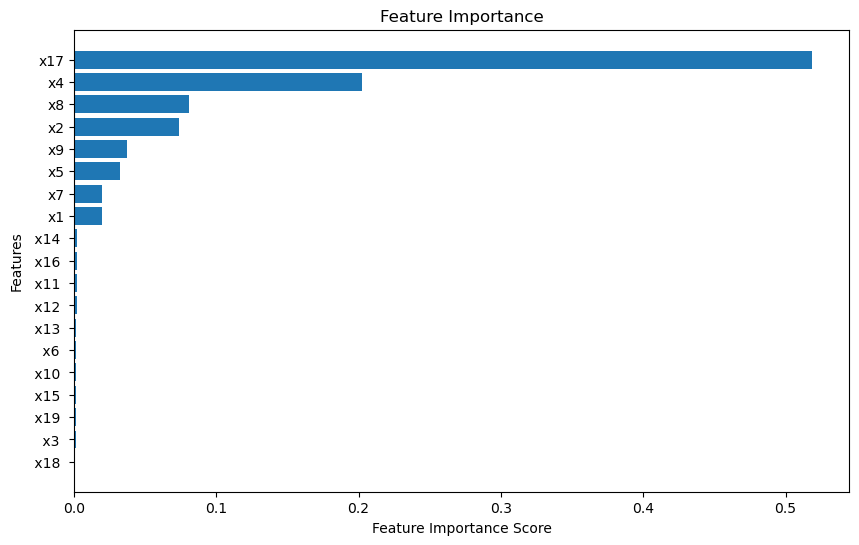

In [4]:
importance_wt = model_wt.feature_importances_
feature_importance_wt = sorted(zip(X.columns, importance_wt), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importance_wt], [x[1] for x in feature_importance_wt])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### Tuned RF, XBG model with cross validation

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0]
    }
}

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror")
}

Performing hyperparameter tuning for Random Forest...


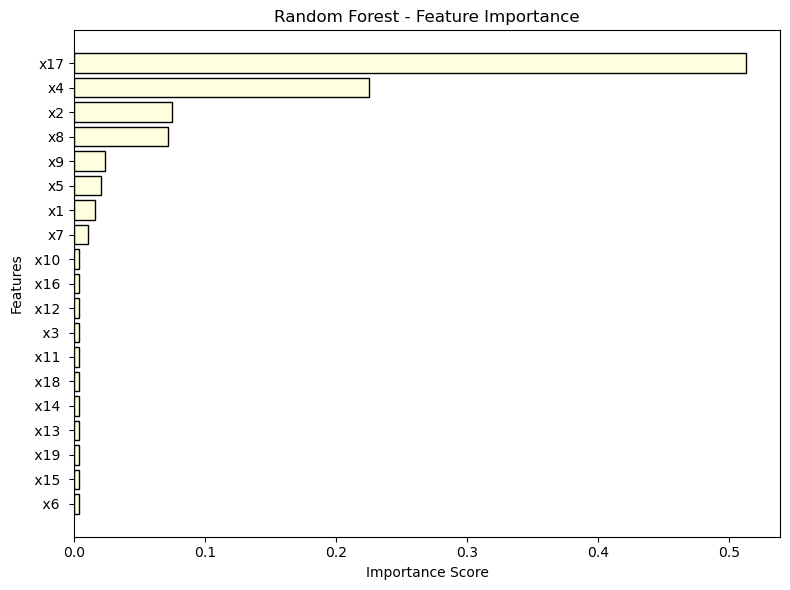

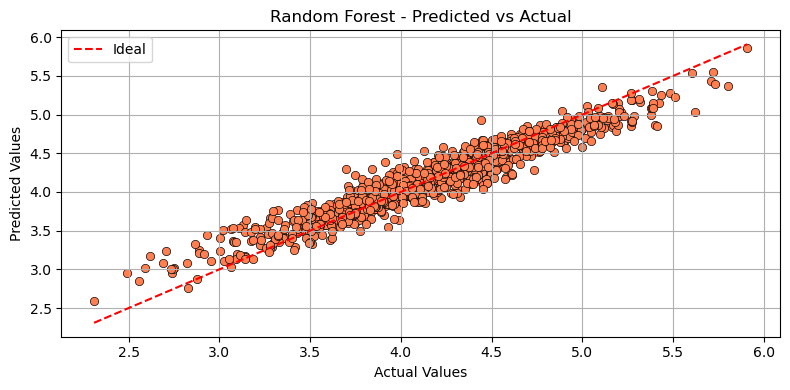

Performing hyperparameter tuning for XGBoost...


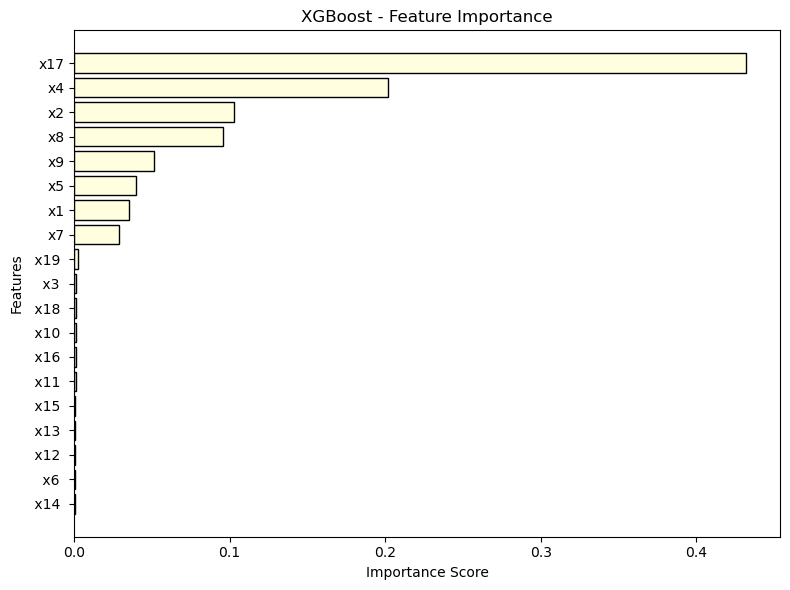

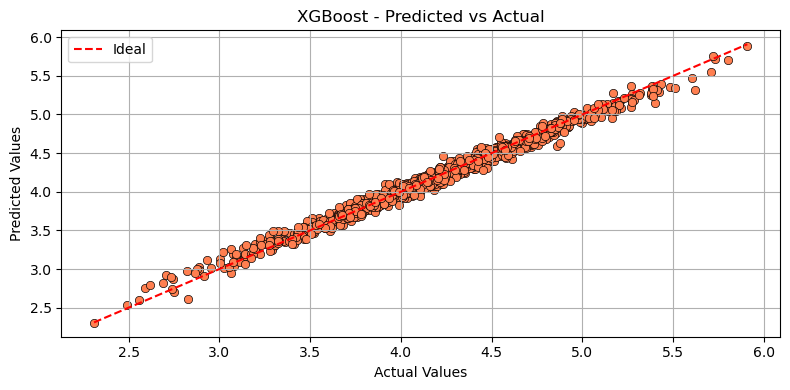

In [6]:
results = {}
best_params = {}
feature_importances = {}

for name, model in models.items():
    print(f"Performing hyperparameter tuning for {name}...")
    grid_search = GridSearchCV(
        model, param_grid=param_grids[name], scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get best model and evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    best_params[name] = grid_search.best_params_
    results[name] = {
        "Test RMSE": rmse,
        "Test R^2": r2
    }

    # Extract feature importance
    if name == "Random Forest":
        importance = best_model.feature_importances_
    elif name == "XGBoost":
        importance = best_model.feature_importances_

    feature_importances[name] = importance
    
    # Plot Feature Importance
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_importances = importance[sorted_idx]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color="lightyellow", edgecolor="black")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Plot Predicted vs Actual
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_test, y=y_pred, color="coral", edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1.5, label="Ideal")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Predicted vs Actual")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [9]:
print("\nResults Summary:")
results_df = pd.DataFrame(results).T
print(results_df)

print("\nBest Hyperparameters:")
for name, params in best_params.items():
    print(f"{name}: {params}")


Results Summary:
               Test RMSE  Test R^2
Random Forest   0.172475  0.904904
XGBoost         0.067871  0.985274

Best Hyperparameters:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


# Reduced Dataset

In [8]:
drift_reduced = drift_all.copy()
drift_reduced.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ',
                              ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)

drift_reduced

,x1,x2,x4,x5,x7,x8,x9,x17,outcome
0,22.780558,43.705158,0.368876,121922.732487,1385.955687,93.024751,450.262165,5720.126727,4.517638
1,21.569469,44.599345,0.346992,135983.426714,1194.062497,98.154152,463.894205,6139.822447,5.584419
2,23.203345,46.169765,0.335544,139371.905910,1186.764858,91.201962,476.599667,5368.044014,4.252761
3,21.389617,45.872145,0.386834,139755.249551,1262.771995,84.234564,438.219964,5988.234459,4.376101
4,22.541639,46.862372,0.378250,142941.299410,1226.814920,99.039988,489.951671,4830.636831,3.499299
...,...,...,...,...,...,...,...,...,...
4995,23.366617,44.796879,0.394306,126484.851233,1408.367471,89.265552,425.725445,5442.982062,3.508562
4996,21.251548,46.989940,0.336320,132907.011038,1289.128906,95.361125,489.677125,5915.764746,5.285910
4997,22.192893,44.707554,0.344509,134691.280666,1214.254590,91.118180,459.425874,6152.864560,5.289742
4998,21.938618,48.933320,0.380520,134210.600517,1262.847499,85.963524,423.680010,5600.703773,3.669122


## Hyperparameter Tuning

In [10]:
# Load reduced dataset
X = drift_reduced.drop(columns=['outcome'])
y = drift_reduced['outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    "learning_rate": np.linspace(0.0001, 0.5, 25),   # Wider range for learning rate
    "max_depth": np.arange(1, 26, 1),               # Depth from 1 to 30
    "subsample": np.linspace(0.1, 1.0, 25),         # From 10% to 100% sampling
    "reg_alpha": np.linspace(0, 10, 25),            # L1 regularization range
    "reg_lambda": np.linspace(0.1, 20, 25)          # L2 regularization range
}

# Function to train and evaluate model
def evaluate_model(param_name, param_values):
    results = []

    for value in param_values:
        # Set other parameters constant and vary only one
        model = xgb.XGBRegressor(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,  
            max_depth=6,
            subsample=0.8,
            reg_alpha=1,
            reg_lambda=1
        )
        setattr(model, param_name, value)  # Set varying parameter

        # Train and predict
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Store results
        results.append([f"{param_name} = {value:.3f}", train_r2, test_r2, train_rmse, test_rmse])

    return pd.DataFrame(results, columns=["Hyperparameter", "Train R2", "Test R2", "Train RMSE", "Test RMSE"])

# Collect results
results_dfs = {
    param: evaluate_model(param, values) for param, values in param_grid.items()
}

In [11]:
for param, df in results_dfs.items():
    print(f"\nResults for {param}:")
    print(df)


Results for learning_rate:
           Hyperparameter  Train R2   Test R2  Train RMSE  Test RMSE
0   learning_rate = 0.000  0.015030  0.013428    0.562947   0.555533
1   learning_rate = 0.021  0.903545  0.854446    0.176165   0.213381
2   learning_rate = 0.042  0.973754  0.938594    0.091894   0.138596
3   learning_rate = 0.063  0.987222  0.959659    0.064119   0.112336
4   learning_rate = 0.083  0.991014  0.968385    0.053769   0.099447
5   learning_rate = 0.104  0.992069  0.969907    0.050514   0.097023
6   learning_rate = 0.125  0.992255  0.967949    0.049920   0.100131
7   learning_rate = 0.146  0.992364  0.971941    0.049566   0.093688
8   learning_rate = 0.167  0.992546  0.969754    0.048971   0.097270
9   learning_rate = 0.188  0.992444  0.968614    0.049305   0.099086
10  learning_rate = 0.208  0.992753  0.968677    0.048286   0.098986
11  learning_rate = 0.229  0.992391  0.968345    0.049479   0.099510
12  learning_rate = 0.250  0.992258  0.967734    0.049908   0.100466
13  le

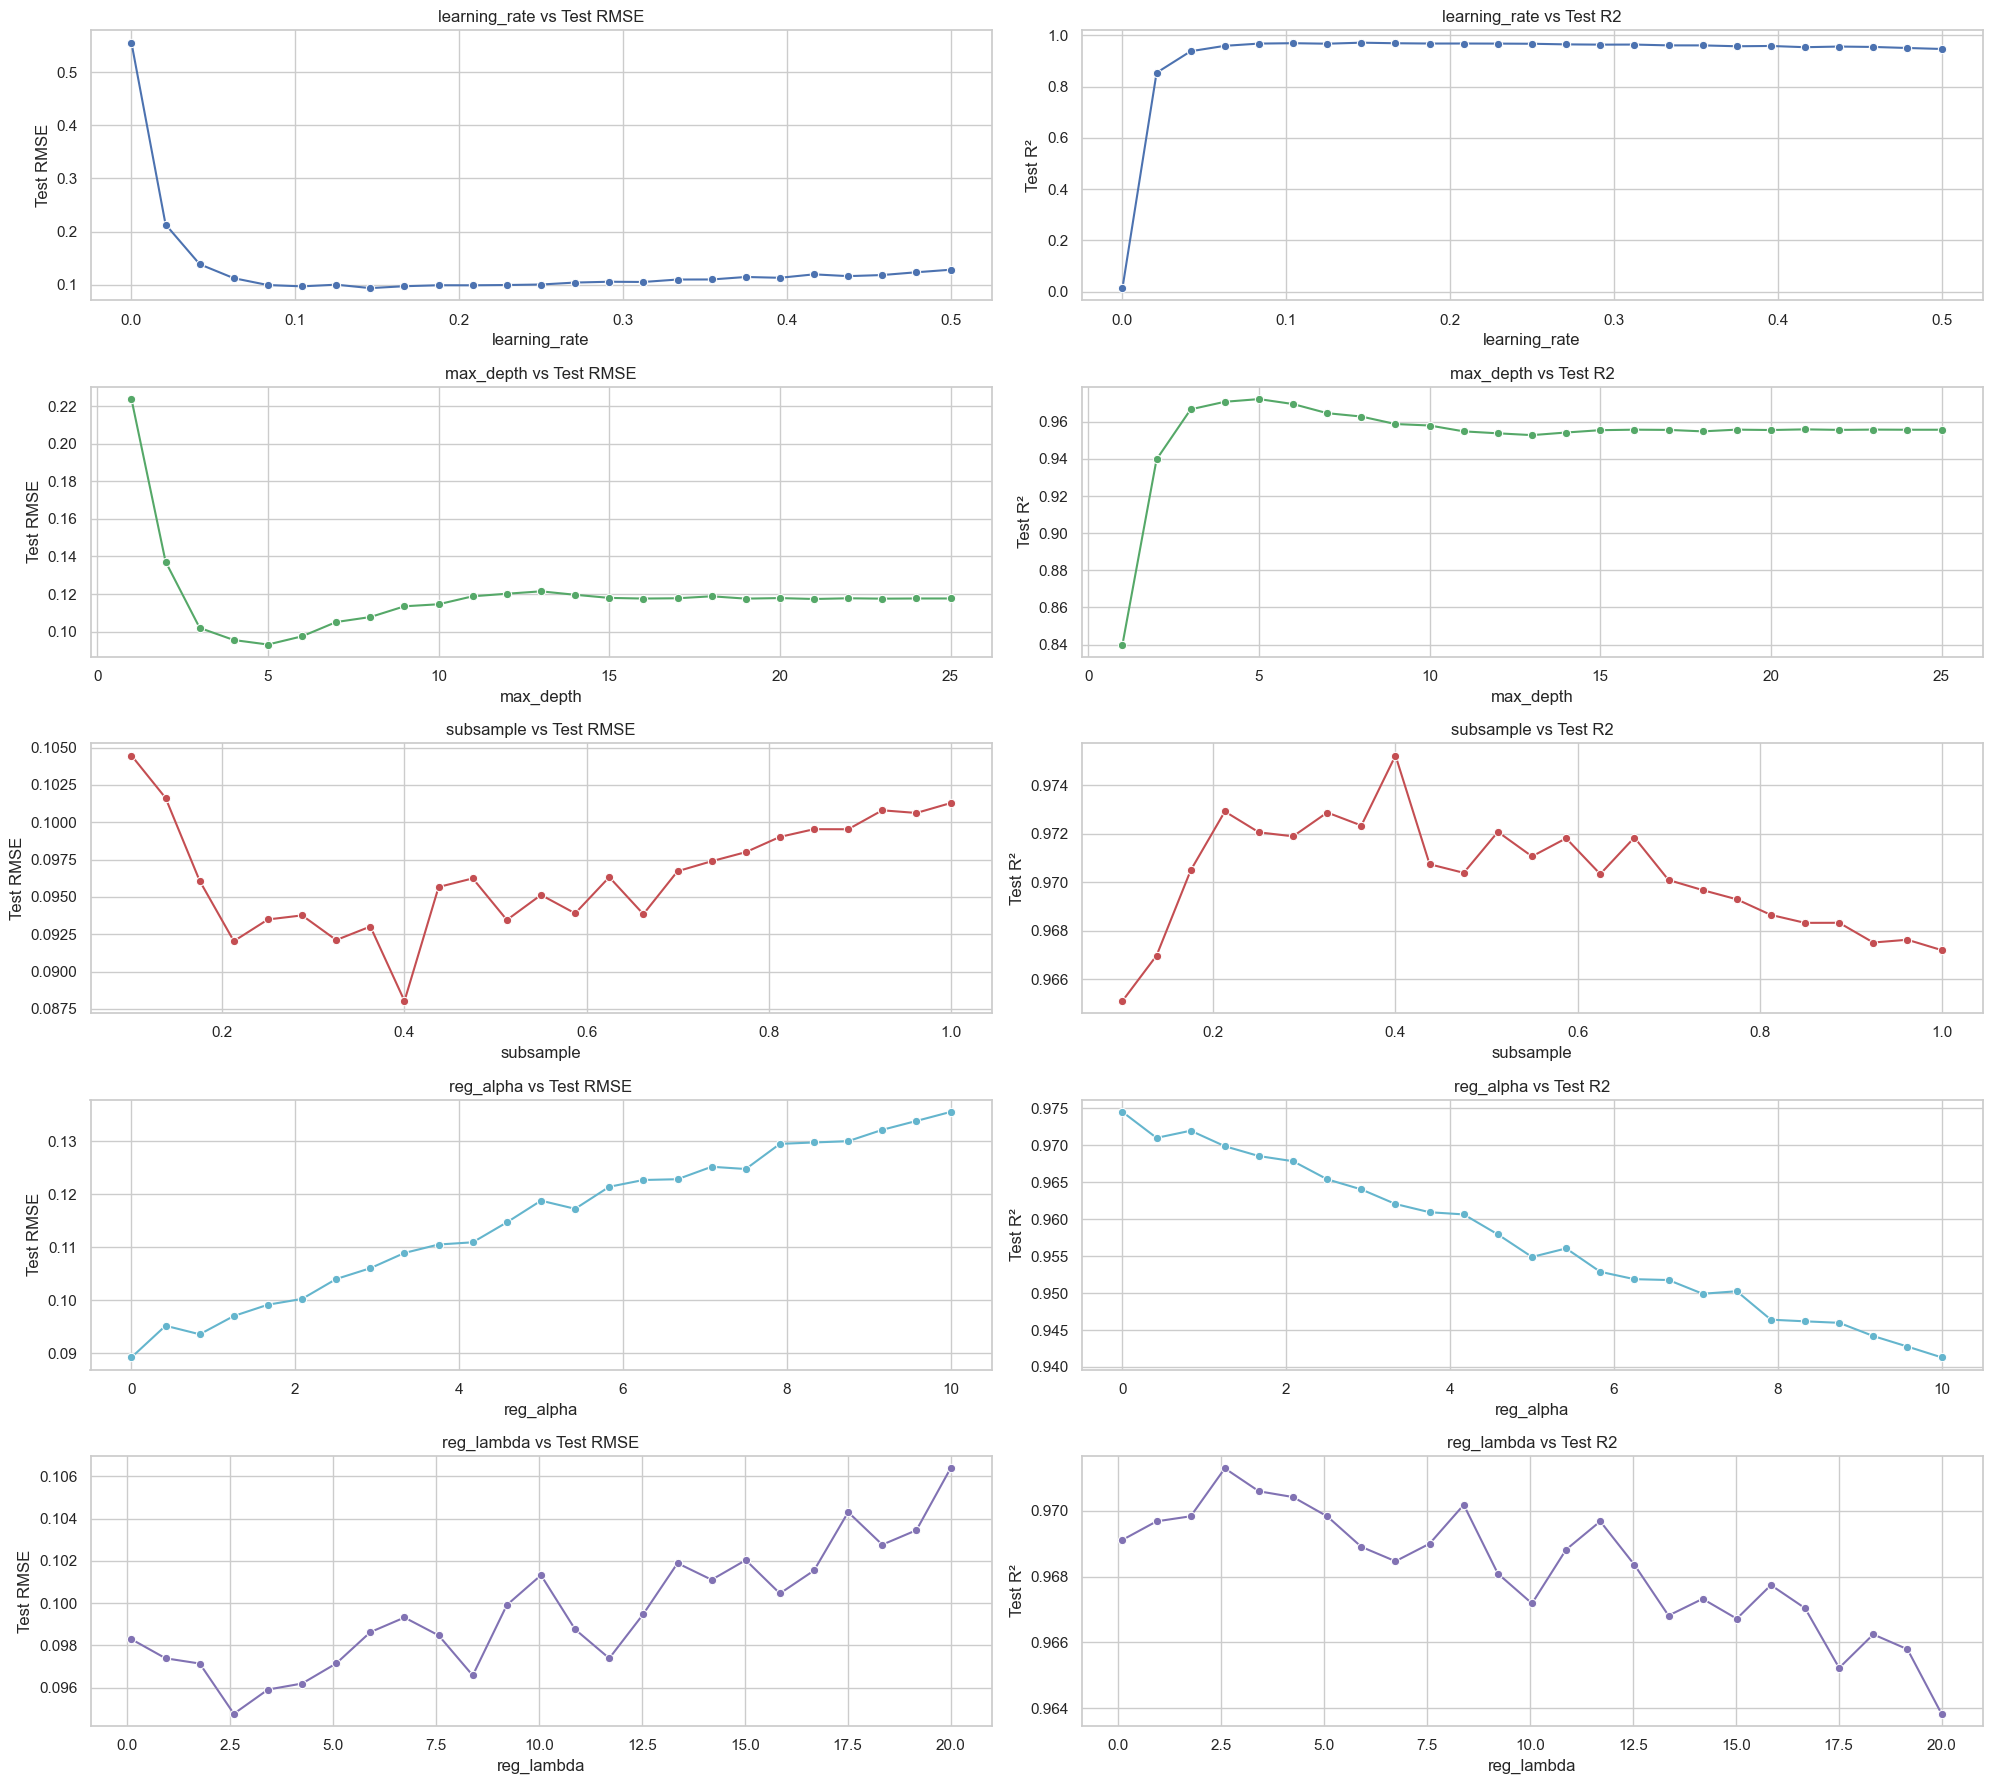

In [12]:
plt.figure(figsize=(20, 18))
sns.set(style="whitegrid")

params_to_plot = list(param_grid.keys())
colors = ['b', 'g', 'r', 'c', 'm']

for i, param in enumerate(params_to_plot):
    param_values = param_grid[param]
    df = results_dfs[param]

    # Test RMSE plot
    plt.subplot(5, 2, i * 2 + 1)
    sns.lineplot(x=param_values, y=df["Test RMSE"].astype(float), marker='o', color=colors[i])
    plt.title(f"{param} vs Test RMSE")
    plt.xlabel(param)
    plt.ylabel("Test RMSE")

    # Test R² plot
    plt.subplot(5, 2, i * 2 + 2)
    sns.lineplot(x=param_values, y=df["Test R2"].astype(float), marker='o', color=colors[i])
    plt.title(f"{param} vs Test R2")
    plt.xlabel(param)
    plt.ylabel("Test R²")

plt.tight_layout()
plt.show()

## Grid Search to find best parameter along with cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load reduced dataset
X = drift_reduced.drop(columns=['outcome'])
y = drift_reduced['outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid

param_grid = {
    "learning_rate": [0.0, 0.1, 0.2, 0.3],
    "max_depth": [2, 3, 4, 5, 6, 7],
    "subsample": [0.2, 0.3, 0.4, 0.5, 0.6],
    "reg_alpha": [0, 1, 2],
    "reg_lambda": [0, 0.5, 1, 1.5, 2.5, 3]
}

# Initialize XGBoost model
model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_scaled, y)

# Best parameters and score
best_params = grid_search.best_params_
best_rmse_cv = -grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation RMSE: {best_rmse_cv:.4f}")

# Train final model with best parameters
best_model = xgb.XGBRegressor(random_state=42, n_estimators=100, **best_params)
best_model.fit(X_scaled, y)

# Train-test split to evaluate the final model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Model Evaluation:")
print(f"Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.2}
Best Cross-Validation RMSE: 0.0751

Final Model Evaluation:
Train RMSE: 0.0507, Train R²: 0.9920
Test RMSE: 0.0508, Test R²: 0.9918



Full Dataset:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'reg_alpha': 0, 'reg_lambda': 3, 'subsample': 0.6}
Best Cross-Validation RMSE: 0.0785

Final Model Evaluation (Full):
Train RMSE: 0.0577, Train R²: 0.9897
Test RMSE: 0.0560, Test R²: 0.9900


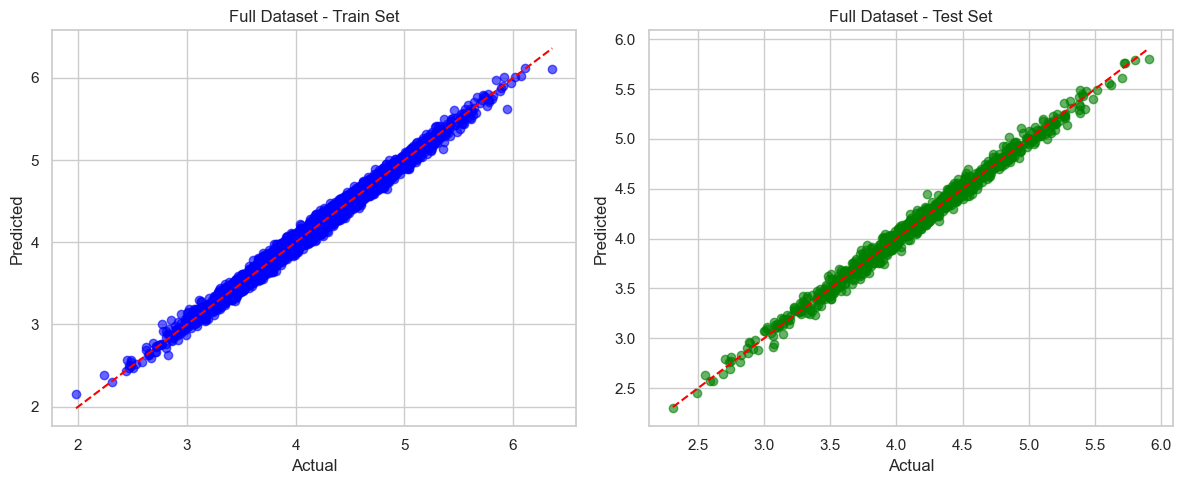

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_grid = {
    "learning_rate": [0.0, 0.1, 0.2, 0.3],
    "max_depth": [2, 3, 4, 5, 6, 7],
    "subsample": [0.2, 0.3, 0.4, 0.5, 0.6],
    "reg_alpha": [0, 1, 2],
    "reg_lambda": [0, 0.5, 1, 1.5, 2.5, 3]
}

def evaluate_dataset(X, y, dataset_name):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize XGBoost model
    model = xgb.XGBRegressor(random_state=42, n_estimators=100)

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid_search.fit(X_scaled, y)

    # Best parameters and score
    best_params = grid_search.best_params_
    best_rmse_cv = -grid_search.best_score_

    print(f"\n{dataset_name} Dataset:")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation RMSE: {best_rmse_cv:.4f}")

    # Train final model with best parameters
    best_model = xgb.XGBRegressor(random_state=42, n_estimators=100, **best_params)
    best_model.fit(X_scaled, y)

    # Train-test split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"\nFinal Model Evaluation ({dataset_name}):")
    print(f"Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")

    # Plot actual vs. predicted
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset_name} Dataset - Train Set')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset_name} Dataset - Test Set')

    plt.tight_layout()
    plt.show()

# Evaluate Full Dataset
X_full = drift_all.drop(columns=['outcome'])
y_full = drift_all['outcome']
evaluate_dataset(X_full, y_full, "Full")





Reduced Dataset:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.2}
Best Cross-Validation RMSE: 0.0751

Final Model Evaluation (Reduced):
Train RMSE: 0.0507, Train R²: 0.9920
Test RMSE: 0.0508, Test R²: 0.9918


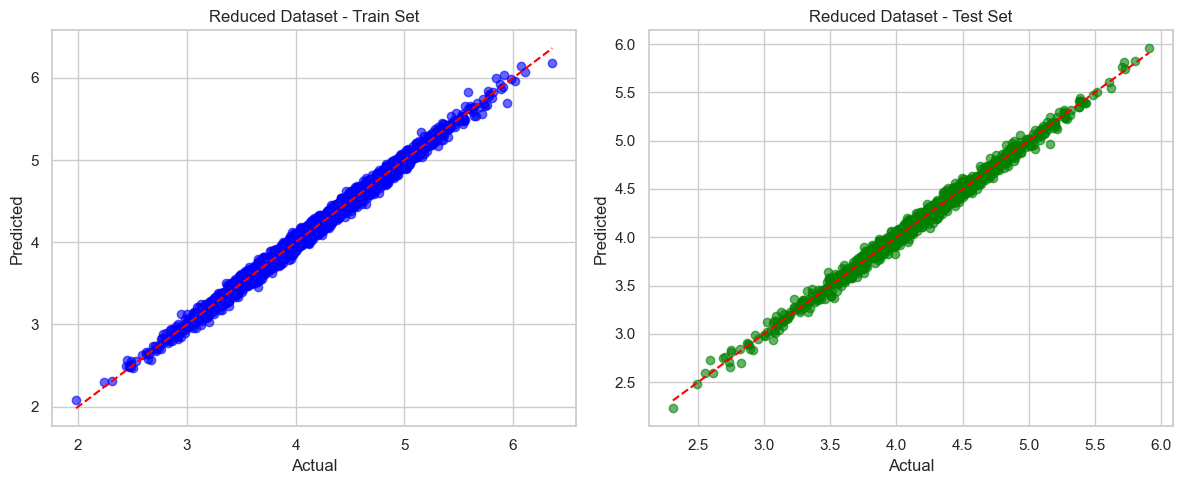

In [17]:
# Evaluate Reduced Dataset
X_reduced = drift_reduced.drop(columns=['outcome'])
y_reduced = drift_reduced['outcome']
evaluate_dataset(X_reduced, y_reduced, "Reduced")

# Testing on Excursion Set


In [19]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
ex_data = excursion_data.copy()  

X_ex = ex_data.drop(columns=['outcome'])
y_ex_actual = ex_data['outcome']  

X_ex_scaled = scaler.fit_transform(X_ex) 

final_model = best_model 
y_ex_pred = final_model.predict(X_ex_scaled)

# Calculate RMSE and R^2
rmse_ex = np.sqrt(mean_squared_error(y_ex_actual, y_ex_pred))
r2_ex = r2_score(y_ex_actual, y_ex_pred)

In [21]:
print(f"RMSE: {rmse_ex:.4f}")
print(f"R^2: {r2_ex:.4f}")

RMSE: 3.5800
R^2: -16.1278


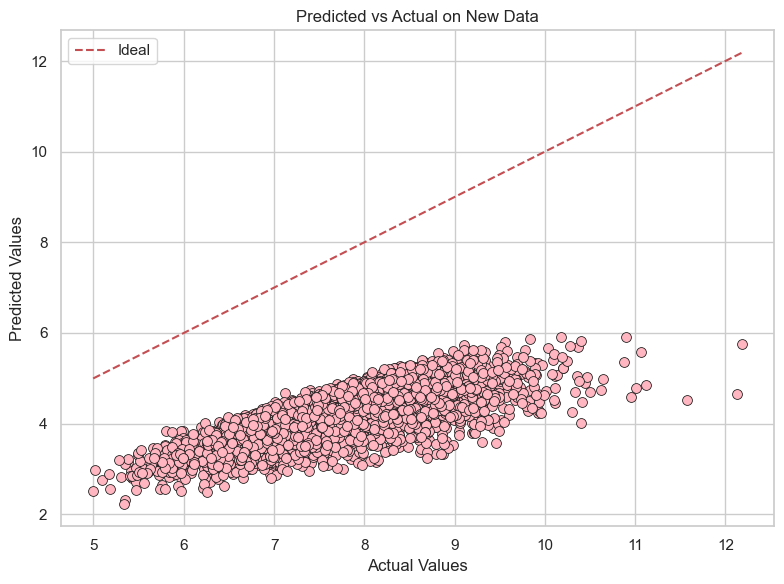

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_ex_actual, y=y_ex_pred, color="lightpink", edgecolor="k", s=50)
plt.plot(
    [y_ex_actual.min(), y_ex_actual.max()],
    [y_ex_actual.min(), y_ex_actual.max()],
    '--r', linewidth=1.5, label="Ideal"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual on New Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()